In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import torch
from torch.distributions import MultivariateNormal
import itertools
from tqdm.notebook import *
import seaborn as sns

### Setup

First we define a set of <code>num_envs</code> environments by for each environment uniformly sampling $N$ points with scores $f(x)$ sampled from a GP over the unit square in $\mathbb R^2$. 

We assume a prior mean of $\mu_0=0$, and use an RBF kernel $K$ controled by a parameter $\tau$ (as $\tau\!\!\nearrow$, the smoothness increases). 

In [2]:
K = lambda x, y: np.exp(-1 / (2 * tau ** 2) \
                           * np.linalg.norm(x[:, None] - y[None, :], axis=2) \
                           ** 2)
u0 = lambda x: np.zeros(len(x))
N = 500
tau = 0.1
num_envs = 6

def make_env():
    pts = np.array([[np.random.uniform(0,1), np.random.uniform(0,1)]
           for i in range(N)])
    scores = np.random.multivariate_normal(u0(pts), K(pts, pts))
    return pts, scores

def make_envs():
    return tuple(map(list, zip(*[
        (*make_env(), np.random.uniform(0, 1)) 
        for _ in range(num_envs)
    ])))

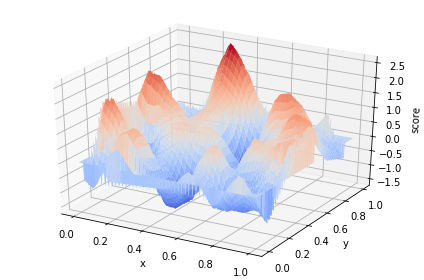

In [3]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata

pts, scores = make_env()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
gx, gy = np.meshgrid(np.arange(0, 1, 2e-3), np.arange(0, 1, 2e-3))
Z = griddata(pts, scores, (gx, gy))
ax.plot_surface(gx, gy, np.nan_to_num(Z), cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('score')
plt.tight_layout()

plt.show()

In [4]:
def GP(x, X, Y, eps=1e-2, K=K, u0=u0, mu_only=False):
    e = lambda n: eps * np.eye(len(n))
    if not len(X):
        return u0(x) if mu_only else (u0(x), K(x, x) + e(x))
    K_xX, K_XX, K_xx = K(x, X), K(X, X), K(x, x)
    u = K_xX @ np.linalg.inv(e(X) + K_XX) \
            @ (Y - u0(Y))[:, None] + u0(x)[:, None]
    if mu_only: return u.reshape(-1)
    S = K_xx + e(x) - K_xX @ \
            np.linalg.inv(K_XX + e(X)) @ K_xX.T
    return u.reshape(-1), S

def fit_kernel(X, Y, epochs=1000, lr=1e-3, eps=1e-2):
    tau = torch.tensor(1., requires_grad=True)
    K = lambda x, y: torch.exp(-1 / (2 * tau ** 2) * torch.tensor(
            np.linalg.norm(x[:, None] - y[None, :], axis=2) ** 2))
    opt = torch.optim.Adam([tau], lr=lr)
    for i in range(epochs):
        opt.zero_grad()
        cov = K(X, X) + eps * torch.eye(len(X))
        loss = -MultivariateNormal(torch.zeros(len(X)), cov).log_prob(torch.tensor(Y))
        loss.backward()
        opt.step()
    return (lambda x, y: K(x, y).detach().numpy())

In [5]:
def run_trial(agent, H):
    Xs, Ys, Rs = make_envs()
    results = [[] for _ in range(num_envs)]
    seen = [[] for _ in range(num_envs)]
    for t in range(H):
        i, j = agent(
            Xs, Rs,
            [np.array(x) for x in seen], 
            [np.array(x) for x in results], 
            H - t
        )
        seen[i].append(Xs[i][j])
        results[i].append(Ys[i][j])
        Xs[i] = np.delete(Xs[i], i, axis=0)
        Ys[i] = np.delete(Ys[i], i, axis=0)
    return sum(r * sum(x) for x, r in zip(results, Rs)), \
           sum(r * max(x, default=0) for x, r in zip(results, Rs))

def run_agent(agent, H, n):
    results = np.array([run_trial(agent, H) for _ in trange(n)])
    means = tuple(results.mean(axis=0))
    stds = tuple(results.std(axis=0) / np.sqrt(n))
    return dict(sum=dict(avg=means[0], se=stds[0]), max=dict(avg=means[1], se=stds[1]))

### Algorithms
Each agent takes 
$(X^{\scriptscriptstyle{(i)}},R^{\scriptscriptstyle{(i)}},
X_{\scriptscriptstyle obs}^{\scriptscriptstyle(i)}, 
Y_{\scriptscriptstyle obs}^{\scriptscriptstyle(i)}, 
H)$ with $(i)$ ranging over all environments.

##### Parameters
$X^{\scriptscriptstyle{(i)}}$: unseen sequences in $i$th environment<br>
$R^{\scriptscriptstyle{(i)}}$: relative weighting of environments<br>
$X_{\scriptscriptstyle obs}^{\scriptscriptstyle{(i)}}$: seen sequences $x$ in $i$th environment<br>
$Y_{\scriptscriptstyle obs}^{\scriptscriptstyle{(i)}}$: seen sequence scores $f(x)$ in $i$th environment<br>
$H$: remaining time horizon

##### Returns
$i, j$: the choice is the $j$th element of the $i$th environment $X^{\scriptscriptstyle(i)}$

<hr>

Test with <code>run_agent(agent, H, n)</code>. Runs agent for $H$ sequential time steps in the previously constructed environment. Returns the sum and maximum of observed scores within each environment, combined with weighting $R$, across $n$ trials, with means and standard errors.

In [6]:
def random(Xs, Rs, X_obs, Y_obs, H):
    i = np.random.choice(num_envs)
    j = np.random.choice(len(Xs[i]))
    return i, j

In [7]:
def greedy(Xs, Rs, X_obs, Y_obs, H):
    mus = [GP(Xs[i], X_obs[i], Y_obs[i], mu_only=True) for i in range(num_envs)]
    obs_best = np.array([x.max(initial=0) for x in Y_obs])
    pred_best = np.array([x.max() for x in mus])
    delta = np.array(Rs) * (pred_best - obs_best)
    i = np.argmax(delta)
    j = np.argmax(mus[i])
    return i, j

In [8]:
eps = 0.2
def egreedy(Xs, Rs, X_obs, Y_obs, H):
    if np.random.random() < eps:
        return random(Xs, Rs, X_obs, Y_obs, H)
    else:
        return greedy(Xs, Rs, X_obs, Y_obs, H)

In [9]:
beta = 1.
def gp_ucb(Xs, Rs, X_obs, Y_obs, H):
    obs_best = np.array([x.max(initial=0) for x in Y_obs])
    mus, sigmas = map(
        np.array, 
        zip(*[GP(Xs[i], X_obs[i], Y_obs[i]) for i in range(num_envs)])
    )
    ucbs = [mu + np.sqrt(beta) * np.diag(sigma) for mu, sigma in zip(mus, sigmas)]
    pred_best = np.array([x.max() for x in ucbs])
    delta = np.array(Rs) * (pred_best - obs_best)
    i = np.argmax(delta)
    j = np.argmax(ucbs[i])
    return i, j

In [10]:
def gp_ts(Xs, Rs, X_obs, Y_obs, H):
    obs_best = np.array([x.max(initial=0) for x in Y_obs])
    mus, sigmas = map(
        np.array, 
        zip(*[GP(Xs[i], X_obs[i], Y_obs[i]) for i in range(num_envs)])
    )
    samples = [np.random.multivariate_normal(mu, sigma) for mu, sigma in zip(mus, sigmas)]
    pred_best = np.array([x.max() for x in samples])
    delta = np.array(Rs) * (pred_best - obs_best)
    i = np.argmax(delta)
    j = np.argmax(samples[i])
    return i, j

In [11]:
def ei_max(Xs, Rs, X_obs, Y_obs, H):
    mus, sigmas = map(
        np.array, 
        zip(*[GP(Xs[i], X_obs[i], Y_obs[i]) for i in range(num_envs)])
    )
    pred_best = np.array([np.max(x, initial=0) for x in Y_obs])
    Zs = [
        (mu - ys) / np.diag(sigma) 
        for mu, sigma, ys in zip(mus, sigmas, pred_best)
    ]
    EI = [
        (mu - ys) * norm.cdf(Z) + np.diag(sigma) * norm.pdf(Z)
        for mu, sigma, ys, Z in zip(mus, sigmas, pred_best, Zs)
    ]
    i = np.argmax([np.max(x) for x in EI])
    j = np.argmax(EI[i])
    return i, j

In [12]:
h = 100

In [13]:
run_agent(random, H=h, n=100)

{'sum': {'avg': 1.2873889570059192, 'se': 0.7967100237618485},
 'max': {'avg': 5.112757186317919, 'se': 0.1366512880527609}}

In [14]:
run_agent(greedy, H=h, n=20)

{'sum': {'avg': 4.243009831214727, 'se': 1.1921079369017613},
 'max': {'avg': 2.60752349444978, 'se': 0.24719978922906663}}

In [15]:
run_agent(egreedy, H=h, n=20)

{'sum': {'avg': 13.969148087632565, 'se': 2.8382886677606987},
 'max': {'avg': 3.6955957065670106, 'se': 0.2828709948298645}}

In [16]:
run_agent(gp_ucb, H=h, n=20)

{'sum': {'avg': 71.78076047773165, 'se': 9.582869808231807},
 'max': {'avg': 5.275194085643635, 'se': 0.3577740437620622}}

In [17]:
run_agent(ei_max, H=h, n=20)

{'sum': {'avg': 26.17309862412276, 'se': 3.1266453889697354},
 'max': {'avg': 6.506083686896967, 'se': 0.3375230170280999}}

In [ ]:
run_agent(gp_ts, H=h, n=10)